In [24]:
import torch
import torch.nn as nn
import torch.optim as optim


In [25]:

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)  
        )
    
    def forward(self, room_params, noise):
        x = torch.cat([room_params, noise], dim=1)  
        return self.model(x)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(19, 512),  # Input size to match room and furniture parameters
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, room_params, furniture_params):
        x = torch.cat([room_params, furniture_params], dim=1)  # Concatenate room and furniture parameters
        return self.model(x)

In [27]:
input_dim = 10  
output_dim = 9  
generator = Generator(20, output_dim)  
discriminator = Discriminator()

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 50
valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

num_epochs = 10000

In [29]:
for epoch in range(num_epochs):
    room_params = torch.randn(batch_size, 10).to(device)  
    furniture_params = torch.randn(batch_size, 9).to(device)  

    noise = torch.randn(batch_size, input_dim).to(device)  
    gen_furniture = generator(room_params, noise)  

    real_loss = adversarial_loss(discriminator(room_params, furniture_params), valid)
    fake_loss = adversarial_loss(discriminator(room_params, gen_furniture.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()
    
    g_loss = adversarial_loss(discriminator(room_params, gen_furniture), valid)

    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [0/10000] D Loss: 0.6941 | G Loss: 0.6376
Epoch [1000/10000] D Loss: 0.2041 | G Loss: 3.1055
Epoch [2000/10000] D Loss: 0.1610 | G Loss: 3.2262
Epoch [3000/10000] D Loss: 0.1666 | G Loss: 3.0228
Epoch [4000/10000] D Loss: 0.0927 | G Loss: 3.3581
Epoch [5000/10000] D Loss: 0.2628 | G Loss: 2.4272
Epoch [6000/10000] D Loss: 0.4687 | G Loss: 1.7862
Epoch [7000/10000] D Loss: 0.3572 | G Loss: 1.7676
Epoch [8000/10000] D Loss: 0.4001 | G Loss: 1.3619
Epoch [9000/10000] D Loss: 0.5869 | G Loss: 1.3119


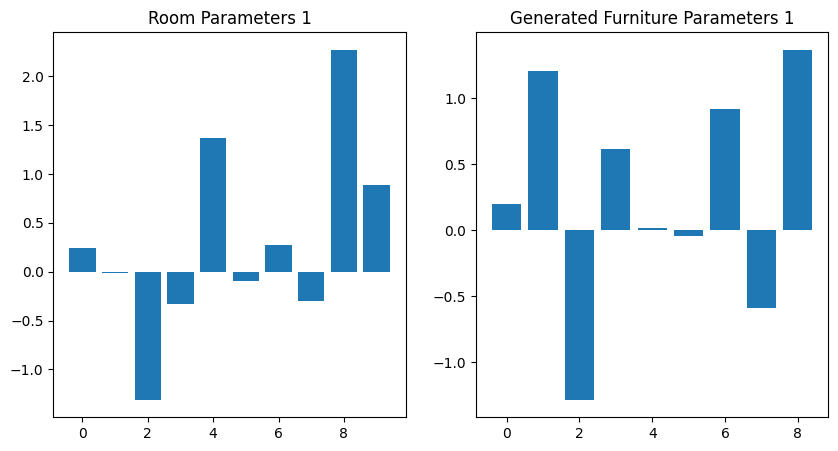

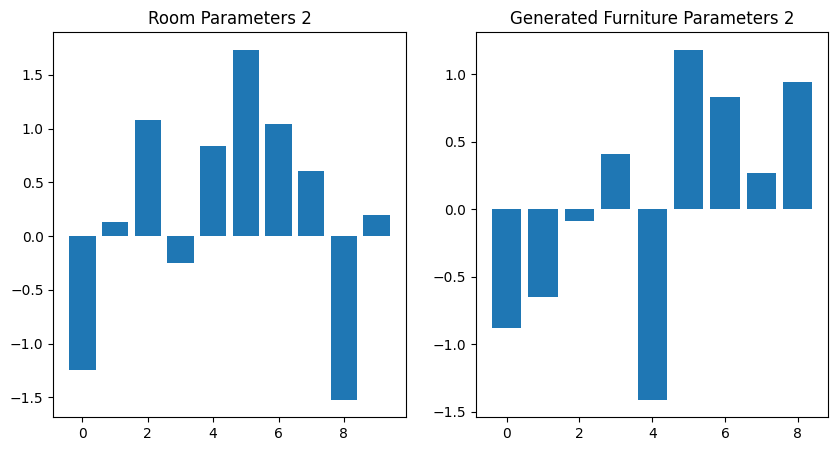

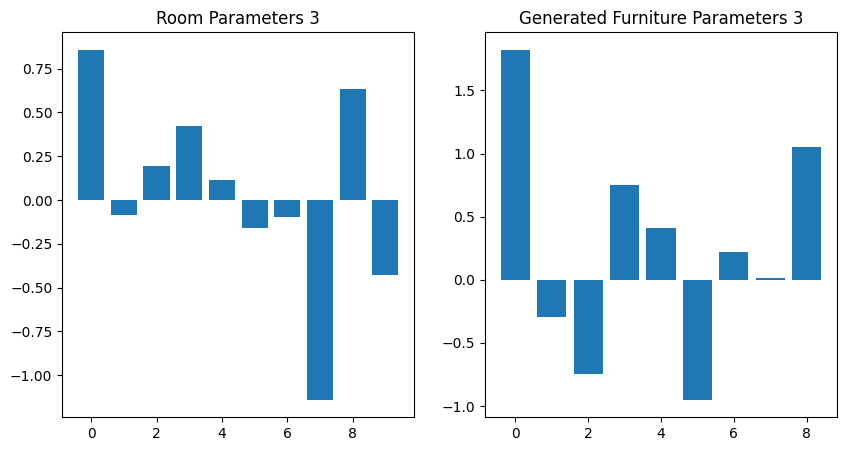

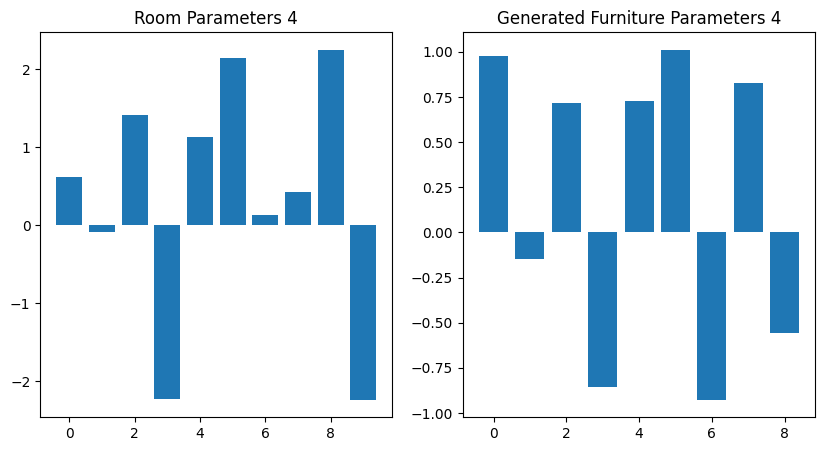

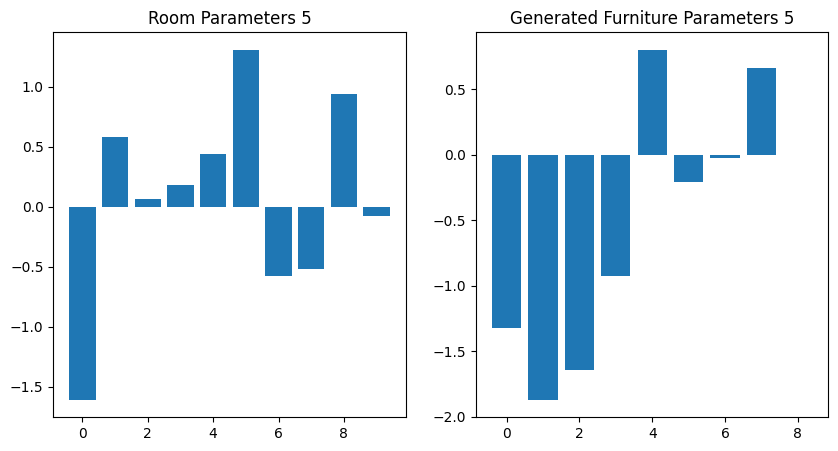

In [8]:
import torch
import matplotlib.pyplot as plt

def generate_furniture(generator, room_params, noise_dim=10):
    noise = torch.randn(room_params.size(0), noise_dim).to(device)
    gen_furniture = generator(room_params.to(device), noise)  
    return gen_furniture

def test_generator(generator, num_samples=5):
    room_params = torch.randn(num_samples, 10).to(device)      
    generated_furniture = generate_furniture(generator, room_params)
    
    return room_params.cpu().detach().numpy(), generated_furniture.cpu().detach().numpy()

room_params, furniture_params = test_generator(generator)
for i in range(len(furniture_params)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Room Parameters {i+1}')
    plt.bar(range(len(room_params[i])), room_params[i])
    
    plt.subplot(1, 2, 2)
    plt.title(f'Generated Furniture Parameters {i+1}')
    plt.bar(range(len(furniture_params[i])), furniture_params[i])
    plt.savefig(f'room_furniture_parameters_{i+1}.png')
    
    plt.show()


In [30]:

room_size = torch.tensor([[10, 12, 8]], dtype=torch.float32).to(device)
style = torch.tensor([[1, 0, 0]], dtype=torch.float32).to(device)  
color = torch.tensor([[0.5, 0.5, 0.5]], dtype=torch.float32).to(device) 
room_params = torch.cat((room_size, style, color), dim=1)  
print("Room Params Shape:", room_params.shape)
input_dim = 20 - room_params.size(1)  
noise = torch.randn(room_params.size(0), input_dim).to(device)  

with torch.no_grad():
 
    print("Room Params Shape:", room_params.shape)
    print("Noise Shape:", noise.shape)

 
    generated_furniture = generator(room_params, noise)

print("Generated Furniture:", generated_furniture)


Room Params Shape: torch.Size([1, 9])
Room Params Shape: torch.Size([1, 9])
Noise Shape: torch.Size([1, 11])
Generated Furniture: tensor([[ 0.3450, -1.8980,  0.3583, -0.5219, -0.2353,  0.4567, -2.2923,  0.3179,
          1.7695]])
